# Lesson 6 - Training & Inference
- 6강에서는 모델을 학습하고 추론하는 방법에 대해 알아보았습니다.
- 이번 실습 자료에서는 다양한 Loss, Optimizer, Scheduler를 활용하는 방법을 알아봅니다.
- 또한, Checkpoint, Early Stopping과 같은 학습을 도와주는 Callback 방법을 알아봅니다.
- 그리고 Graident Accumulation 방법을 활용하여 학습을 진행해봅니다.


## 1. Loss
- Image Classification에 사용되는 다양한 loss 함수들이 존재합니다. 각 loss 함수는 목적이 있고 풀고자 하는 문제에 맞게 적용을 해야합니다.
- Cross Entropy Loss는 두 분포간의 불확실성을 최소화 하는 목적을 가진 분류에 사용되는 일반적인 손실함수입니다.
- Focal Loss는 Imbalanced Data 문제를 해결하기 위한 손실함수입니다. [참고](https://arxiv.org/pdf/1708.02002.pdf)
- Label Smoothing은 학습 데이터의 representation을 더 잘나타내는데 도움을 줍니다. [참고](https://arxiv.org/pdf/1906.02629.pdf)
- F1 Loss는 F1 score 향상을 목적으로 하는 손실함수입니다.

###### 베이스라인 코드 train.py 파일 중 Loss 관련 부분.
- default 로 cross_entropy로 설정되어 있지만 FocalLoss, LabelSmoothingLoss, F1Loss로 바꿔서 적용해 봅시다!

In [1]:
# -- loss & metric
criterion = create_criterion(args.criterion)  # default: cross_entropy

NameError: name 'create_criterion' is not defined

###### 베이스라인 코드 loss.py 파일.
- FocalLoss, LabelSmoothingLoss, F1Loss, cross_entropy 중에 원하는 Loss 를 설정하여 학습시킬 수 있습니다. 
또한 직접 커스터마이징한 Loss를 추가해서 적용해 볼수 있습니다! (아래쪽 Reference를 참고하세요)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
# https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon
    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

In [ ]:
_criterion_entrypoints = {
    'cross_entropy': nn.CrossEntropyLoss,
    'focal': FocalLoss,
    'label_smoothing': LabelSmoothingLoss,
    'f1': F1Loss
}

## 2. Optimizer
- 파이토치는 코드를 간단히 수정하여 다양한 optimizer를 사용할 수 있습니다.
- 이번 실습 자료에서는 Adam 과 SGD Optimizer 를 활용하는 방법을 알아봅니다.


### 2.1 예제를 통해 그래프로 이해하기
- 예제를 통해 Optimizer 따라 Loss 값이 변하는 추이를 그래프를 통해서 이해해봅시다.
- 비교할 Optimizer 는 베이스라인 코드에서 default 로 사용된 SGD와 Adam Optimizer 입니다.

In [2]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

import torch.nn as nn

# -- 기본 모델 정의.
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)   # 은닉층
        self.predict = torch.nn.Linear(20, 1)   # 결과층

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # 결과.
        return x


In [3]:
# -- Hyperparameter 정의.
LR = 0.01  #Learning rate
BATCH_SIZE = 32 
EPOCH = 15 

x = torch.unsqueeze(torch.linspace(-1,1,1000),dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(x.size()))

# -- 데이터셋 생성.
torch_dataset = Data.TensorDataset(x,y)
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

In [4]:
# -- 각 optimizer를 사용한 신경망 정의.
net_SGD = Net()
net_Adam = Net()

# -- 각 신경망 리스트.
nets = [net_SGD, net_Adam]

# -- 각 Optimizer 정의.
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR) # SGD Optimizer
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9,0.99)) # Adam Optimizer

# -- 각 Optimizer 리스트.
optimizers = [opt_SGD, opt_Adam]

# -- Loss 계산.
loss_func = torch.nn.MSELoss()
# -- Loss 기록.
losses_his = [[],[]]

In [5]:
#-- Training 
for epoch in range(EPOCH):
    print("[INFO] Training Epoch : {}".format(epoch))
    for step, (batch_x,batch_y) in enumerate(loader):
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
                
        for net, opt, l_his in zip(nets, optimizers, losses_his):
            output = net(b_x) 
            loss = loss_func(output, b_y) #각 신경망의 Loss 계산.
            
            opt.zero_grad() 
            loss.backward() 
            opt.step() 
            

            l_his.append(loss.item()) 
print("[INFO] Training ALL DONE!!!")

[INFO] Training Epoch : 0
[INFO] Training Epoch : 1
[INFO] Training Epoch : 2
[INFO] Training Epoch : 3
[INFO] Training Epoch : 4
[INFO] Training Epoch : 5
[INFO] Training Epoch : 6
[INFO] Training Epoch : 7
[INFO] Training Epoch : 8
[INFO] Training Epoch : 9
[INFO] Training Epoch : 10
[INFO] Training Epoch : 11
[INFO] Training Epoch : 12
[INFO] Training Epoch : 13
[INFO] Training Epoch : 14
[INFO] Training ALL DONE!!!


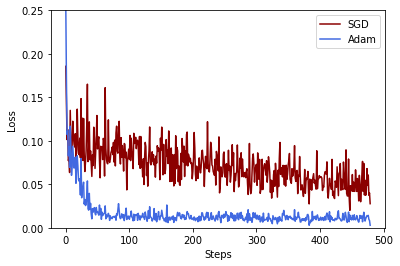

In [6]:
#-- 그래프로 시각화.
labels = ['SGD', 'Adam']
colors = ['darkred', 'royalblue']
for i, l_his in enumerate(losses_his):
    plt.plot(l_his, label=labels[i], color=colors[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim(0,0.25)  
plt.show()

- 그래프를 통해 Adam 의 Loss 값이 SGD에서 더 낮은것을 확인할 수 있습니다! 실제로 베이스라인 코드에 적용해 볼까요?

### 2.2 베이스라인 코드에 적용하며 이해하기

- 이번엔 베이스라인 코드에서 SGD Optimizer를 먼저 적용해 보고 Adam Optimizer를 적용한 결과의 Loss와 Accuracy의 변화를 비교해 살펴보겠습니다.
- 결론 부터 말씀드리면 Adam(Adaptive moment estimation) Optimizer 는 다른 stochastic optimization methods(SGD, Adagrad, RMSProp)에 비해 optimizer 성능이 좋은 편입니다! 실제로 확인해볼까요? [참고](https://arxiv.org/pdf/1412.6980.pdf)


- 다음은 베이스라인 코드중 train.py 파일의 일부분 입니다. 

###### Libraries & Configurations

In [7]:
import argparse
import glob
import json
import os
import random
import re
from importlib import import_module
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import MaskBaseDataset
from loss import create_criterion


def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

ModuleNotFoundError: No module named 'dataset'

###### Loss

In [ ]:
# -- loss & metric
criterion = create_criterion(args.criterion)  # default: cross_entropy

- 아래쪽의 Optimizer를 적용하는 부분은 다음과 같이 간단히 한줄로 적용할 수도 있습니다.
###### SGD optimizer
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=5e-4)
###### Adam optimizer
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-4)

###### Optimizer

In [ ]:
opt_module = getattr(import_module("torch.optim"), args.optimizer)  # default: SGD
optimizer = opt_module(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=args.lr,
    weight_decay=5e-4
)

###### Scheduler

In [ ]:
scheduler = StepLR(optimizer, args.lr_decay_step, gamma=0.5)

- SGD Optimizer 결과.

Epoch[98/100](20/241) || training loss 2.278 || training accuracy 26.56% || lr 6.25e-05

Epoch[98/100](40/241) || training loss 2.261 || training accuracy 28.44% || lr 6.25e-05

Epoch[98/100](60/241) || training loss 2.258 || training accuracy 28.75% || lr 6.25e-05

Epoch[98/100](80/241) || training loss 2.286 || training accuracy 28.83% || lr 6.25e-05

Epoch[98/100](100/241) || training loss  2.3 || training accuracy 28.05% || lr 6.25e-05

Epoch[98/100](120/241) || training loss 2.298 || training accuracy 26.48% || lr 6.25e-05

Epoch[98/100](140/241) || training loss 2.232 || training accuracy 28.75% || lr 6.25e-05

Epoch[98/100](160/241) || training loss 2.338 || training accuracy 26.56% || lr 6.25e-05

Epoch[98/100](180/241) || training loss 2.206 || training accuracy 29.61% || lr 6.25e-05

Epoch[98/100](200/241) || training loss  2.3 || training accuracy 25.86% || lr 6.25e-05

Epoch[98/100](220/241) || training loss 2.269 || training accuracy 27.89% || lr 6.25e-05

Epoch[98/100](240/241) || training loss 2.294 || training accuracy 27.97% || lr 6.25e-05

Calculating validation results...
[Val] acc : 24.71%, loss:  2.3 || best acc : 24.80%, best loss:  2.3

Epoch[99/100](20/241) || training loss 2.258 || training accuracy 28.98% || lr 6.25e-05

Epoch[99/100](40/241) || training loss 2.273 || training accuracy 27.66% || lr 6.25e-05

Epoch[99/100](60/241) || training loss 2.299 || training accuracy 25.47% || lr 6.25e-05

Epoch[99/100](80/241) || training loss 2.325 || training accuracy 26.02% || lr 6.25e-05

Epoch[99/100](100/241) || training loss 2.27 || training accuracy 26.25% || lr 6.25e-05

Epoch[99/100](120/241) || training loss 2.237 || training accuracy 29.38% || lr 6.25e-05

Epoch[99/100](140/241) || training loss 2.281 || training accuracy 27.89% || lr 6.25e-05

Epoch[99/100](160/241) || training loss 2.264 || training accuracy 28.91% || lr 6.25e-05

Epoch[99/100](180/241) || training loss 2.256 || training accuracy 30.16% || lr 6.25e-05

Epoch[99/100](200/241) || training loss 2.304 || training accuracy 28.12% || lr 6.25e-05

Epoch[99/100](220/241) || training loss 2.262 || training accuracy 29.38% || lr 6.25e-05

Epoch[99/100](240/241) || training loss 2.282 || training accuracy 27.42% || lr 6.25e-05

Calculating validation results...
[Val] acc : 24.80%, loss:  2.3 || best acc : 24.80%, best loss:  2.3

- Adam Optimizer 결과로, Optimizer 만 바꿨을 뿐인데 확연히 낮아진 Loss값과 향상된 Accuracy 를 확인할 수 있습니다

Epoch[98/100](20/241) || training loss 0.3912 || training accuracy 86.72% || lr 6.25e-05

Epoch[98/100](40/241) || training loss 0.4169 || training accuracy 86.72% || lr 6.25e-05

Epoch[98/100](60/241) || training loss 0.4019 || training accuracy 86.56% || lr 6.25e-05

Epoch[98/100](80/241) || training loss 0.428 || training accuracy 85.70% || lr 6.25e-05

Epoch[98/100](100/241) || training loss 0.4092 || training accuracy 85.78% || lr 6.25e-05

Epoch[98/100](120/241) || training loss 0.4237 || training accuracy 86.33% || lr 6.25e-05

Epoch[98/100](140/241) || training loss 0.4093 || training accuracy 86.25% || lr 6.25e-05

Epoch[98/100](160/241) || training loss 0.3903 || training accuracy 87.19% || lr 6.25e-05

Epoch[98/100](180/241) || training loss 0.4056 || training accuracy 86.64% || lr 6.25e-05

Epoch[98/100](200/241) || training loss 0.408 || training accuracy 86.72% || lr 6.25e-05

Epoch[98/100](220/241) || training loss 0.4367 || training accuracy 84.92% || lr 6.25e-05

Epoch[98/100](240/241) || training loss 0.4363 || training accuracy 85.55% || lr 6.25e-05

Calculating validation results...
[Val] acc : 68.12%, loss: 0.71 || best acc : 68.30%, best loss:  0.7

Epoch[99/100](20/241) || training loss 0.3987 || training accuracy 87.11% || lr 6.25e-05

Epoch[99/100](40/241) || training loss 0.4065 || training accuracy 87.89% || lr 6.25e-05

Epoch[99/100](60/241) || training loss 0.4084 || training accuracy 86.25% || lr 6.25e-05

Epoch[99/100](80/241) || training loss 0.4135 || training accuracy 86.56% || lr 6.25e-05

Epoch[99/100](100/241) || training loss 0.4168 || training accuracy 85.78% || lr 6.25e-05

Epoch[99/100](120/241) || training loss 0.3895 || training accuracy 86.48% || lr 6.25e-05

Epoch[99/100](140/241) || training loss 0.4228 || training accuracy 85.62% || lr 6.25e-05

Epoch[99/100](160/241) || training loss 0.4314 || training accuracy 85.86% || lr 6.25e-05

Epoch[99/100](180/241) || training loss 0.4434 || training accuracy 84.92% || lr 6.25e-05

Epoch[99/100](200/241) || training loss 0.4697 || training accuracy 84.53% || lr 6.25e-05

Epoch[99/100](220/241) || training loss 0.3847 || training accuracy 87.73% || lr 6.25e-05

Epoch[99/100](240/241) || training loss 0.4097 || training accuracy 85.86% || lr 6.25e-05

Calculating validation results...
[Val] acc : 67.80%, loss:  0.7 || best acc : 68.30%, best loss:  0.7

## 3. Scheduler
- Scheduler은 optimizer의 learning rate를 동적으로 변경시키는 기능을 합니다.
- Optimizer과 Scheduler를 적절히 활용하면 모델이 좋은 성능으로 Fitting하는데 도움을 줍니다.

In [ ]:
# -- scheduler: StepLR
# 지정된 step마다 learning rate를 감소시킵니다.
scheduler = StepLR(optimizer, lr_decay_step, gamma=0.5)

In [ ]:
# -- scheduler: ReduceLROnPlateau
# 성능이 향상되지 않을 때 learning rate를 줄입니다. patience=10은 10회 동안 성능 향상이 없을 경우입니다.
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

In [ ]:
# -- scheduler: CosineAnnealingLR
# CosineAnnealing은 learning rate를 cosine 그래프처럼 변화시킵니다.
scheduler = CosineAnnealingLR(optimizer, T_max=2, eta_min=0.)

## 4. Metric
- Classification 성능을 표현할 때 다양한 평가지표가 있습니다.
- Accuracy: 모델이 정확하게 예측한 객체의 비율
- True Positive(TP): 실제 True인 정답을 True라고 예측 (정답)
- False Positive(FP): 실제 False인 정답을 True라고 예측 (오답)
- False Negative(FN): 실제 True인 정답을 False라고 예측 (오답)
- True Negative(TN): 실제 False인 정답을 False라고 예측 (정답)
- Precision(정밀도): TP / (TP + FP)
- Recall(재현율): TP / (TP + FN)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

In [ ]:
# -- Accuracy
accuracy_score(y_true, y_pred)

In [ ]:
# -- Accuracy
# Normalize를 안하면 맞춘 개수가 표시된다
accuracy_score(y_true, y_pred, normalize=False)

In [ ]:
# -- Precision
precision = precision_score(y_true, y_pred, average='macro')
precision

In [ ]:
# -- Recall
recall = recall_score(y_true, y_pred, average='macro')
recall

In [ ]:
# -- f1 score
2 * (precision * recall) / (precision + recall)

In [ ]:
# -- f1 score (sklearn)
f1_score(y_true, y_pred, average='macro')

## 5. Training process

In [ ]:
dataset = MaskMultiClassDataset(img_root, label_path, 'train')
n_val = int(len(dataset) * val_split)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])
val_set.dataset.set_phase("test")  # todo : fix

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

### 5.1 Callback - Checkpoint, Early Stopping

In [ ]:
# -- Callback1: Checkpoint - Accuracy가 높아질 때마다 모델을 저장합니다.
# 학습 코드에서 이어집니다.

# -- Callback2: Early Stopping - 성능이 일정 기간동안 향상이 없을 경우 학습을 종료합니다.
patience = 10
counter = 0
# 학습 코드에서 이어집니다.

### 5.2 Training Method - Gradient Accumulation
- Graident Accumulation은 한 iteration에 파라미터를 업데이트시키는게 아니라, gradient를 여러 iteration 동안 쌓아서 업데이트시킵니다. 한 번에 파라미터를 업데이트시키는 건 noise가 있을 수 있으므로, 여러번 쌓아서 한번에 업데이트 시킴으로써 그러한 문제를 방지하기 위함입니다.

In [ ]:
# -- Gradient Accumulation
accumulation_steps = 2
# 학습코드에서 이어집니다.

### 5.3 Training Loop

In [ ]:
os.makedirs(os.path.join(os.getcwd(), 'results', name), exist_ok=True)

counter = 0
best_val_acc = 0
best_val_loss = np.inf
for epoch in range(num_epochs):
    # train loop
    model.train()
    loss_value = 0
    matches = 0
    for idx, train_batch in enumerate(train_loader):
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)

        loss.backward()
        
        # -- Gradient Accumulation
        if (idx+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        if (idx + 1) % train_log_interval == 0:
            train_loss = loss_value / train_log_interval
            train_acc = matches / batch_size / train_log_interval
            current_lr = scheduler.get_last_lr()
            print(
                f"Epoch[{epoch}/{num_epochs}]({idx + 1}/{len(train_loader)}) || "
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
            )

            loss_value = 0
            matches = 0

    scheduler.step()

    # val loop
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()
        val_loss_items = []
        val_acc_items = []
        for val_batch in val_loader:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss = np.sum(val_loss_items) / len(val_loader)
        val_acc = np.sum(val_acc_items) / len(val_set)
        
        # Callback1: validation accuracy가 향상될수록 모델을 저장합니다.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_acc > best_val_acc:
            print("New best model for val accuracy! saving the model..")
            torch.save(model.state_dict(), f"results/{name}/{epoch:03}_accuracy_{val_acc:4.2%}.ckpt")
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
        # Callback2: patience 횟수 동안 성능 향상이 없을 경우 학습을 종료시킵니다.
        if counter > patience:
            print("Early Stopping...")
            break
        
        
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )

## 6. Reference
- [sumni blog post](https://sumniya.tistory.com/26)
- [How to create a custom loss function in PyTorch](https://neptune.ai/blog/pytorch-loss-functions)